In [1]:
import nengo
import nengo_spa as spa
import numpy as np
from random import shuffle
import random
import sys, os
import math
from IPython import display

# Import our classes
sys.path.append('..')
import experiments as xps
from modules import Processor, Button, get_senders

# Select Nengo simulator according to whether we want to use ocl or not
use_ocl = True
if use_ocl:
    import nengo_ocl
    simulator = nengo_ocl.Simulator
else:
    simulator = nengo.Simulator
    


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cycler import cycler
%matplotlib inline
default_cycler = cycler('color', ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
plt.rc('axes', prop_cycle=(default_cycler))


def get_senders(processors):
    return [p for p in processors if p.sender]


# Model variables

In [2]:
if True: # random seed
    seed = np.random.randint(999)
    print("Warning: setting random seed")
else:
    seed = 1
print("seed:",seed)
np.random.seed(seed)
random.seed(seed)


s = spa.sym
D = 128*3  # the dimensionality of the vectors
PROC_FDBCK = 0
GW_FDBCK = .95 # but synapse is shorter than for perfect storage
GW_SCALE = 20 # scale the input of GW for saturation and catching very short visual stimuli
BG_THR = .2
BG_BIAS = .5
STIM_SCALE = 1
FIX_SCALE = 1
STIM_DURATION = .029

# Number of neurons (per dimension or ensemble)
scale_npds = 1
npd_AM = int(50*scale_npds) # Default: 50
npd_state = int(50*scale_npds) # Default: 50
npd_BG = int(100*scale_npds) # Default: 100
npd_thal1 = int(50*scale_npds) # Default: 50
npd_thal2 = int(40*scale_npds) # Default: 40
n_scalar = int(50*scale_npds) # Default: 50

n_blocks_per_operation = 1 # default: 10
n_trials_per_digit = 1 # default: 5
n_different_digits = 1 # default: 4
n_different_operations = 3 # default: 3

number_of_total_trials = n_blocks_per_operation * n_trials_per_digit * n_different_digits * n_different_operations
number_of_non_learning_trials = number_of_total_trials
number_of_learning_trials = max(0,number_of_total_trials - number_of_non_learning_trials)
print("number_of_learning_trials",number_of_learning_trials) 
print("number_of_non_learning_trials",number_of_non_learning_trials) 
print("number_of_total_trials",number_of_total_trials)


keys = ['TWO','FOUR','SIX','EIGHT', \
        'FIXATE', \
               'MORE','LESS', \
    'SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB']

vocab = spa.Vocabulary(dimensions=D, pointer_gen=np.random.RandomState(seed), max_similarity=.02)
vocab.populate(";".join(keys))
vocab.populate('SOURCE ; CONTENT ;'+
                  'G ; V ; COM ; ADD ; SUB ; PM')
vocab.populate(";".join([p+"_SOURCE=(SOURCE*"+p+").normalized()" for p in ['V', 'COM', 'ADD', 'SUB']])) # this is done to avoid similarity with other SPs

trials = xps.createTrials(n_blocks_per_operation, n_trials_per_digit, n_different_digits, n_different_operations, shuffle=False)
xp = xps.Xp1(number_of_learning_trials, trials, fixation="FIXATE", stim_scale=STIM_SCALE, fix_scale=FIX_SCALE, stim_duration=STIM_DURATION)
#xp = xps.TestMasking(.083, number_of_learning_trials, trials, fixation="0")

T = number_of_total_trials * xp.trial_length - .00001# simulations run a bit too long
print('T',T)



seed: 163
number_of_learning_trials 0
number_of_non_learning_trials 3
number_of_total_trials 3
T 6.08699


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=384, M=8, similarity=0.02)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=384, M=11, similarity=0.03)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=384, M=14, similarity=0.04)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=384, M=15, similarity=0.04)
  len(self._key2idx), best_sim))
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: User

# Create model

In [3]:
np.random.seed(seed)
random.seed(seed)

model = spa.Network(seed=seed)
with model:
    
    model.config[spa.State].neurons_per_dimension = npd_state
    model.config[spa.Scalar].n_neurons = n_scalar
    model.config[spa.BasalGanglia].n_neurons_per_ensemble = npd_BG
    model.config[spa.Thalamus].neurons_action = npd_thal1
    model.config[spa.Thalamus].neurons_channel_dim = npd_thal1
    model.config[spa.Thalamus].neurons_gate = npd_thal2
    
    inputs_net = spa.Network(label='inputs')

    # We start defining the buffer slots in which information can
    # be placed:
    
    # A slot for the goal/task
    G = spa.State(vocab, label='G')
    with inputs_net:
        G_input = spa.Transcode(xp.G_input, output_vocab = vocab)
    G_input >> G
    
    # A slot for the visual input (the digit N). Feedback is used for iconic memory (100-300ms)
    V_mapping = {
        digit:'CONTENT*'+digit for digit in ['TWO','FOUR','SIX','EIGHT','FIXATE']
    }
    with inputs_net:
        RETINA_input = spa.Transcode(xp.RETINA_input,output_vocab = vocab)
        
    V = Processor(
        vocab, vocab, 'V', V_mapping, 
        receiver=False,
        feedback=PROC_FDBCK,
        npd_AM=npd_AM, seed=seed
    )
    nengo.Connection(RETINA_input.output, V.input, synapse=None)
#     RETINA.output >> V.input
    
    # A slot for the action (MORE or LESS)
    PM = Processor(
        vocab, vocab, 'PM',
        AM_mapping = {stim:stim+'*CONTENT' for stim in ['MORE','LESS']},
        #AM_cls=spa.WTAAssocMem,
        #AM_thr=0.2,
        #AM_fn=lambda x: x>0,
        feedback=PROC_FDBCK,
        sender=False,# add_ON=False,
        npd_AM=npd_AM, seed=seed
    )
            
    BTN = nengo.Node(Button([vocab.parse('CONTENT*LESS').v, vocab.parse('CONTENT*MORE').v], xp.trial_length), size_in=D)
    nengo.Connection(PM.AM.output, BTN)

    # An associative memory for the + operation
    ADD = Processor(
        vocab, vocab, 'ADD',
        AM_mapping = {
            'TWO':'FOUR*CONTENT',
            'FOUR':'SIX*CONTENT',
            'SIX':'EIGHT*CONTENT',
            'EIGHT':'TWO*CONTENT'
        },
        feedback=PROC_FDBCK,
        npd_AM=npd_AM, seed=seed
    )
    
    # An associative memory for the - operation
    SUB = Processor(
        vocab, vocab, 'SUB',
        AM_mapping = {
            'TWO':'EIGHT*CONTENT',
            'FOUR':'TWO*CONTENT',
            'SIX':'FOUR*CONTENT',
            'EIGHT':'SIX*CONTENT'
        },
        feedback=PROC_FDBCK,
        npd_AM=npd_AM, seed=seed
    )
    
    # An associative memory for the "compare to 5" operation
    COM = Processor(
        vocab, vocab, 'COM',
        AM_mapping = {
            'TWO':'LESS*CONTENT',
            'FOUR':'LESS*CONTENT',
            'SIX':'MORE*CONTENT',
            'EIGHT':'MORE*CONTENT'
        },
        feedback=PROC_FDBCK,
        npd_AM=npd_AM, seed=seed
    )
    
    processors = [V, ADD, SUB, COM, PM]

    # A slot that combines selected information from the processors
#     GW = spa.State(vocab, label='GW', feedback=GW_FDBCK)
    GW_content = spa.WTAAssocMem(
        threshold=0, 
        input_vocab=vocab, 
        output_vocab=vocab,
        mapping=['TWO','FOUR','SIX','EIGHT', 'FIXATE', 'MORE','LESS'],
        function=lambda x:x>0,
        label='GW content',
        n_neurons = npd_AM
    )
    for ens in GW_content.all_ensembles:
        nengo.Connection(ens, ens, transform=GW_FDBCK, synapse=.05)
    
    GW_source = spa.WTAAssocMem(
        threshold=0, 
        input_vocab=vocab, 
        output_vocab=vocab,
        mapping=[p.label for p in get_senders(processors)],
        function=lambda x:x>0,
        label='GW source',
        n_neurons = npd_AM
    )
    for ens in GW_source.all_ensembles:
        nengo.Connection(ens, ens, transform=GW_FDBCK, synapse=.05)
    
    PREV = spa.ThresholdingAssocMem(
        threshold=0, 
        input_vocab=vocab, 
        output_vocab=vocab,
        mapping=['FIXATE','V','COM','ADD','SUB'],
#         function=lambda x:x>0,
        label='PREV',
        n_neurons = npd_AM
    )
    for ens in PREV.all_ensembles:
        nengo.Connection(ens, ens, transform=.75, synapse=.05)
    
    # access network
    access_labels = []
    with spa.Network(label='conscious access') :
        with spa.ActionSelection() as access:
            for p in processors:
                if p.sender:
                    access_labels.append(p.label)
                    spa.ifmax(p.label, BG_BIAS+spa.dot(p.preconscious, s.SOURCE*vocab.parse(p.label)) * p.attention,
                                  GW_SCALE * p.preconscious * ~s.CONTENT >> GW_content.input,
                                  GW_SCALE * vocab.parse(p.label) >> GW_source.input,
                                  
                             )
            #access_labels.append("Thresholder")
            #spa.ifmax(BG_BIAS+BG_THR)   
    
    # broadcast network
    with spa.Network(label='broadcast'):
        for p in processors: # each processor p receives GW's content if p's "receive" level is more than a threshold
            if p.receiver:
                with spa.ActionSelection() as broadcast:
                    spa.ifmax("GO", p.receive,
                                 GW_content >> p.input
                             )
                    spa.ifmax("NOGO", .5)
       
    # routing network
    routing_labels = []
    with spa.Network(label='routing'):
        with spa.ActionSelection() as routing:
            
            routing_labels.append("ATTEND")
            spa.ifmax("ATTEND",  BG_BIAS + spa.dot(GW_source, s.V) * spa.dot(GW_content, s.FIXATE),
                          s.FIXATE >> PREV,
                          *(.5 >> p.attention if p==V else -.5 >> p.attention for p in get_senders(processors))
                     )
            
            routing_labels.append("V_COM")
            spa.ifmax("V_COM", BG_BIAS + spa.dot(GW_source, s.V) * spa.dot(G, s.SIMPLE) - spa.dot(GW_content, s.FIXATE) - spa.dot(PREV, s.V),
                          1 >> COM.receive,
                          s.V >> PREV,
                          *(.5 >> p.attention if p==COM else -.5 >> p.attention for p in get_senders(processors))
                     )

            routing_labels.append("V_SUB")
            spa.ifmax("V_SUB", BG_BIAS + spa.dot(GW_source, s.V) * spa.dot(G, s.CHAINED_SUB) - spa.dot(GW_content, s.FIXATE) - spa.dot(PREV, s.V),
                          1 >> SUB.receive,
                          s.V >> PREV,
                          *(.5 >> p.attention if p==SUB else -.5 >> p.attention for p in get_senders(processors))
                     )

            routing_labels.append("V_ADD")
            spa.ifmax("V_ADD", BG_BIAS + spa.dot(GW_source, s.V) * spa.dot(G, s.CHAINED_ADD) - spa.dot(GW_content, s.FIXATE) - spa.dot(PREV, s.V),
                          1 >> ADD.receive,
                          s.V >> PREV,
                          *(.5 >> p.attention if p==ADD else -.5 >> p.attention for p in get_senders(processors))
                     )

            routing_labels.append("ADD_COM")
            spa.ifmax("ADD_COM", BG_BIAS + spa.dot(GW_source, s.ADD) * spa.dot(PREV, s.V),
                          1 >> COM.receive,
                          s.ADD >> PREV,
                          *(.5 >> p.attention if p==COM else -.5 >> p.attention for p in get_senders(processors))
                     )

            routing_labels.append("SUB_COM")
            spa.ifmax("SUB_COM", BG_BIAS + spa.dot(GW_source, s.SUB) * spa.dot(PREV, s.V),
                          1 >> COM.receive,
                          s.SUB >> PREV,
                          *(.5 >> p.attention if p==COM else -.5 >> p.attention for p in get_senders(processors))
                     )

            routing_labels.append("COM_PM")
            spa.ifmax("COM_PM", BG_BIAS + spa.dot(GW_source, s.COM) * (spa.dot(PREV, s.ADD) + spa.dot(PREV, s.SUB) + spa.dot(PREV, s.V)),
                          s.COM >> PREV,
                          1 >> PM.receive,
                     )            

            #routing_labels.append("Thresholder")
            #spa.ifmax("Thresholder", BG_BIAS+BG_THR) # Threshold for action




# Set up some probes

In [4]:
with model:
    
    probe_dt = .05
    probe_synapse = .015
    p_V = nengo.Probe(V.input, synapse = probe_synapse)#, sample_every = probe_dt)
    p_V_out = nengo.Probe(V.AM.output, synapse = probe_synapse)#, sample_every = probe_dt)
#     p_V_filter = nengo.Probe(V.filter.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_G = nengo.Probe(G.output, synapse = probe_synapse)#, sample_every = probe_dt)

    p_GW_content = nengo.Probe(GW_content.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_GW_source = nengo.Probe(GW_source.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_PREV = nengo.Probe(PREV.output, synapse = probe_synapse)#, sample_every = probe_dt)

    p_ADD = nengo.Probe(ADD.input, synapse = probe_synapse)#, sample_every = probe_dt)
    p_ADD_out = nengo.Probe(ADD.AM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_SUB = nengo.Probe(SUB.input, synapse = probe_synapse)#, sample_every = probe_dt)
    p_SUB_out = nengo.Probe(SUB.AM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_COM = nengo.Probe(COM.input, synapse = probe_synapse)#, sample_every = probe_dt)
    p_COM_out = nengo.Probe(COM.AM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    
    p_PM = nengo.Probe(PM.input, synapse = probe_synapse)#, sample_every = probe_dt)
    p_PM_out = nengo.Probe(PM.AM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_BTN = nengo.Probe(BTN)#, sample_every = probe_dt)
    
    p_routing_in = nengo.Probe(routing.bg.input, synapse = probe_synapse)
    p_routing_out = nengo.Probe(routing.thalamus.output, synapse = probe_synapse)
    p_access_in = nengo.Probe(access.bg.input, synapse = probe_synapse)
    p_access_out = nengo.Probe(access.thalamus.output, synapse = probe_synapse)

    
    p_attentions = {}
    for p in processors:
        if p.sender:
            p_attentions[p] = nengo.Probe(p.attention.output, synapse = probe_synapse)

# Run the model

In [5]:
dt = .001
print("Number of neurons:", model.n_neurons)
print("T:",T)
with simulator(model, dt = dt, seed=seed) as sim:
    sim.run(T)

Number of neurons: 187920
T: 6.08699
No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [6]:
print(model.n_neurons)

187920


# Plot results

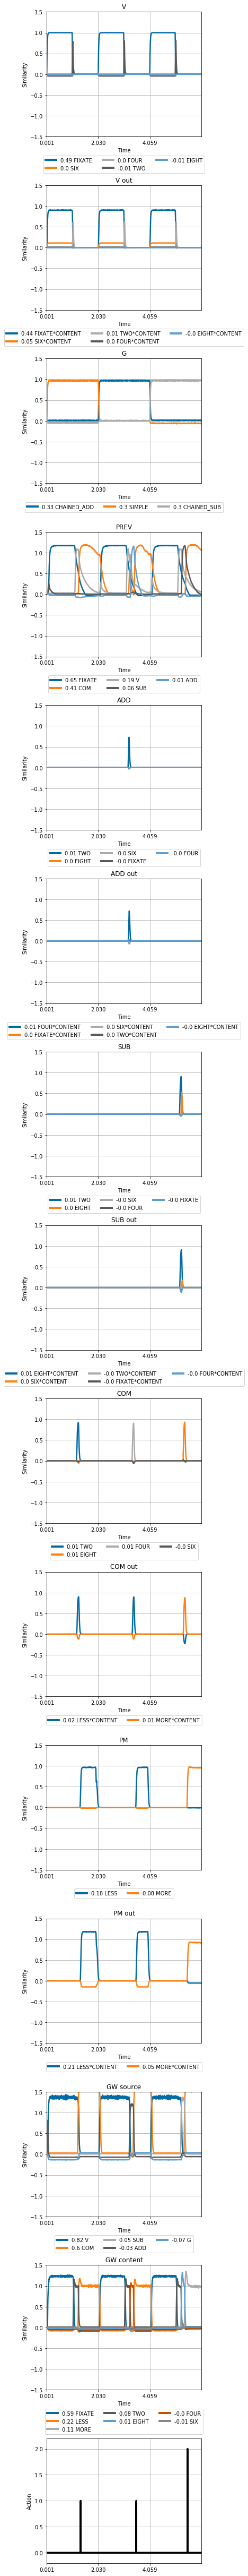

In [7]:
if True:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        ymin, ymax = -1.5, 1.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(True)
        plt.plot(t_range, spa.similarity(data, vectors[sort_idx]), linewidth=2.5)
        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Similarity")
        plt.xlim(left=t_range[0], right=t_range[-1])
        plt.xticks(np.arange(t_range[0], t_range[-1], xp.trial_length))
        leg = plt.legend([str(round(mean_activation[sort_idx][i],2))+' '+k for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center',
                   bbox_to_anchor=(0.5, -0.13), ncol=3)
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()

        return subplot_i + 1



    subplot_nrows=15
    subplot_ncols=1
    plt.figure(figsize=(6*subplot_ncols,4.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*xp.trial_length
    
    focus_start = 0 # first trial to plot
    n_focus = 12 # how many trials to plot
    start = trial_t(focus_start)
    end = trial_t(focus_start+n_focus)
    skip = 5
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


    subplot_i=plot_similarities(trange, sim.data[p_V][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','FIXATE'], title='V', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_V_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['TWO','FOUR','SIX','EIGHT','FIXATE']], title='V out', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_G][selected_idx][::skip], vocab, keys=['SIMPLE','CHAINED_SUB','CHAINED_ADD'], title='G', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PREV][selected_idx][::skip], vocab, keys=['FIXATE','V','COM','ADD','SUB'], title='PREV', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ADD][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','FIXATE'], title='ADD', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ADD_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['TWO','FOUR','SIX','EIGHT','FIXATE']], title='ADD out', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_SUB][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','FIXATE'], title='SUB', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_SUB_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['TWO','FOUR','SIX','EIGHT','FIXATE']], title='SUB out', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_COM][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT'], title='COM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_COM_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['MORE','LESS']], title='COM out', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PM][selected_idx][::skip], vocab, keys=['MORE','LESS'], title='PM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PM_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['MORE','LESS']], title='PM out', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_GW_source][selected_idx][::skip], vocab, keys=["G", "V", "ADD", "SUB", "COM"], title='GW source', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_GW_content][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT', 'FIXATE', 'MORE','LESS'], title='GW content', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)

    trange = sim.trange()[selected_idx]
    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.plot(trange, sim.data[p_BTN][selected_idx], color='black', linewidth=3.5)
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length))
    plt.ylim(-.2,2.2)
    plt.ylabel("Action")
    plt.grid(True)
    
    plt.tight_layout()

    plt.show()
    
    


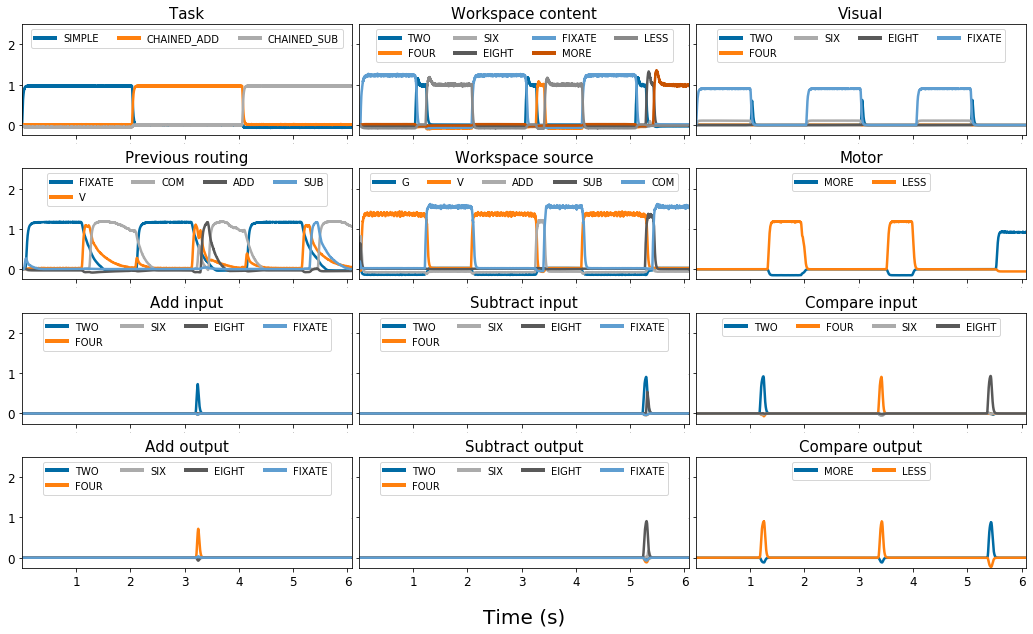

In [8]:
if True:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        ymin, ymax = -.25, 2.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(False)
        plt.plot(t_range, spa.similarity(data, vectors), linewidth=2.5)
        plt.title(title, size=15)
        if subplot_i==11:
            plt.xlabel("Time (s)", size=20, labelpad=20)
#         plt.ylabel("Similarity", size=15)
        plt.xlim(left=t_range[0], right=t_range[-1])
        leg = plt.legend([k.replace('*CONTENT','') for k in keys], loc='upper center', ncol=5 if title=="Workspace source" else 4)
#         leg = plt.legend([k.replace('*CONTENT','')+': '+str(round(mean_activation[sort_idx][i],2)) for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center', ncol=3)
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()
            
        plt.yticks(range(3), range(3), fontsize=12 if (subplot_i-1)%3==0 else 0)
        plt.xticks(range(1,7), range(1,7), fontsize=12 if subplot_i in [10,11,12] else 0)


        return subplot_i + 1

    

    subplot_nrows=4
    subplot_ncols=3
    plt.figure(figsize=(6*subplot_ncols,2.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*xp.trial_length
    
    focus_start = 0 # first trial to plot
    n_focus = 5 # how many trials to plot
    start = trial_t(focus_start)
    end = trial_t(focus_start+n_focus)
    skip = 1
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


    subplot_i=plot_similarities(trange, sim.data[p_G][selected_idx][::skip], vocab, keys=['SIMPLE','CHAINED_ADD','CHAINED_SUB'], title='Task', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_GW_content][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT', 'FIXATE', 'MORE','LESS'], title='Workspace content', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_V_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['TWO','FOUR','SIX','EIGHT','FIXATE']], title='Visual', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PREV][selected_idx][::skip], vocab, keys=['FIXATE','V','COM','ADD','SUB'], title='Previous routing', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#     subplot_i=plot_similarities(trange, sim.data[p_V][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','FIXATE'], title='Visual', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_GW_source][selected_idx][::skip], vocab, keys=["G", "V", "ADD", "SUB", "COM"], title='Workspace source', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PM_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['MORE','LESS']], title='Motor', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ADD][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','FIXATE'], title='Add input', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_SUB][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','FIXATE'], title='Subtract input', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_COM][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT'], title='Compare input', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ADD_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['TWO','FOUR','SIX','EIGHT','FIXATE']], title='Add output', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_SUB_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['TWO','FOUR','SIX','EIGHT','FIXATE']], title='Subtract output', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_COM_out][selected_idx][::skip], vocab, keys=[stim+"*CONTENT" for stim in ['MORE','LESS']], title='Compare output', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#     subplot_i=plot_similarities(trange, sim.data[p_PM][selected_idx][::skip], vocab, keys=['MORE','LESS'], title='Motor input', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)

#     trange = sim.trange()[selected_idx]
#     plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
#     plt.plot(trange, sim.data[p_BTN][selected_idx], color='black', linewidth=3.5)
#     plt.xlim(left=trange[0], right=trange[-1])
#     plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length))
#     plt.ylim(-.2,2.2)
#     plt.ylabel("Action")
#     plt.grid(True)

#     plt.text(-1.1,-1.5,'Time (s)', fontdict={"fontsize":20})
#     plt.text(-7.7,9.5,'Similarity', fontdict={"fontsize":20}, rotation=90)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.02)
    
    plt.savefig("figures/model_beha.eps")

    plt.show()
    
    


# Attention

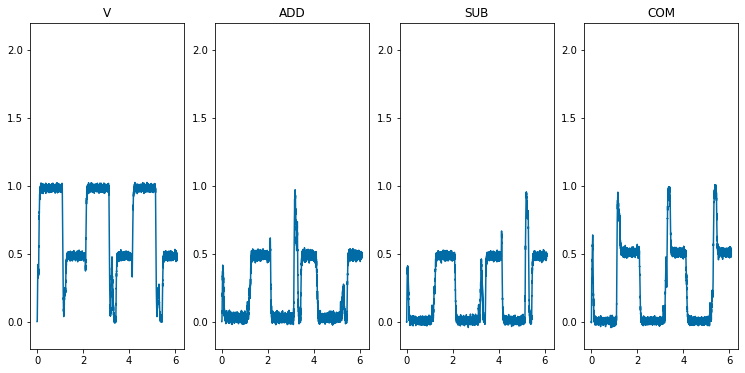

In [9]:
plt.figure(figsize=(16,6))
i=0
for p in processors:
    if p.sender:
        plt.subplot(1,len(processors),i+1)
        plt.plot(trange, sim.data[p_attentions[p]][selected_idx])
        plt.title(p.label)
        plt.ylim(-.2,2.2)
        i += 1
plt.show()

# Access

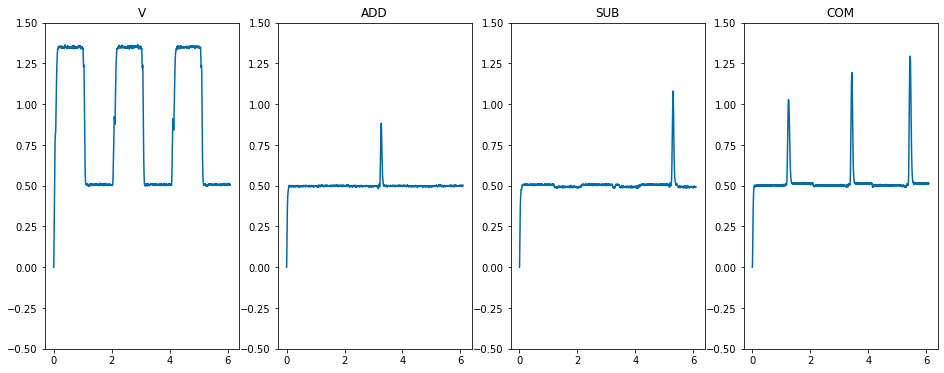

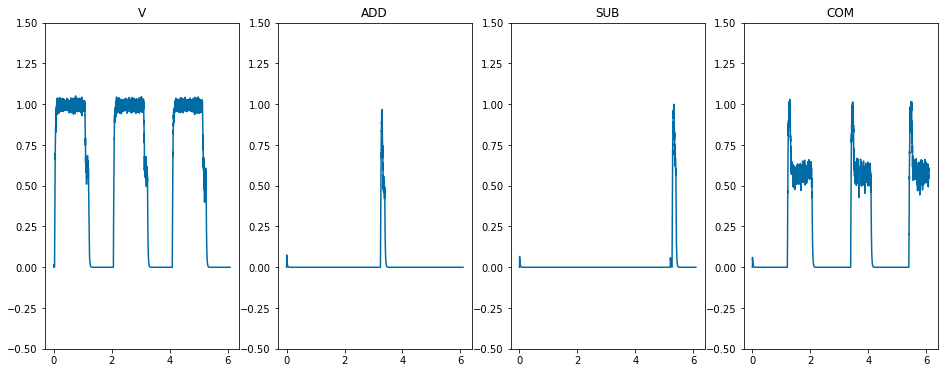

In [10]:
plt.figure(figsize=(16,6))
for i in range(access.bg.input.size_out):
    plt.subplot(1,access.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[p_access_in][:,i][selected_idx])
    plt.title(access_labels[i])
    plt.ylim(-.5,1.5)

plt.show()

plt.figure(figsize=(16,6))
for i in range(access.bg.input.size_out):
    plt.subplot(1,access.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[p_access_out][:,i][selected_idx])
    plt.title(access_labels[i])
    plt.ylim(-.5,1.5)

plt.show()

# Routing

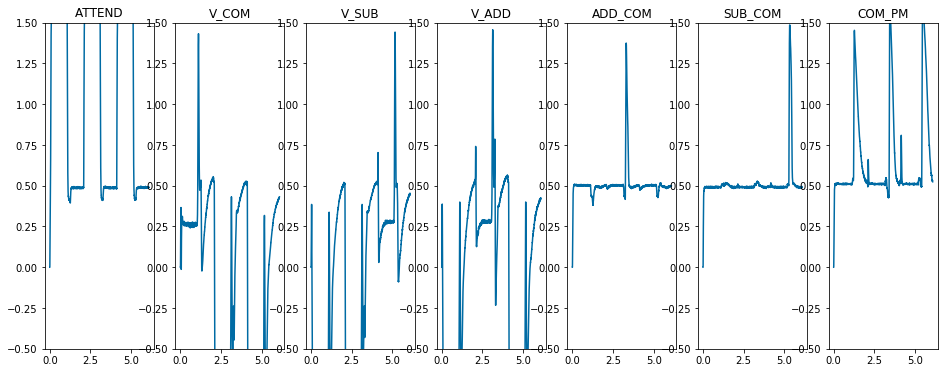

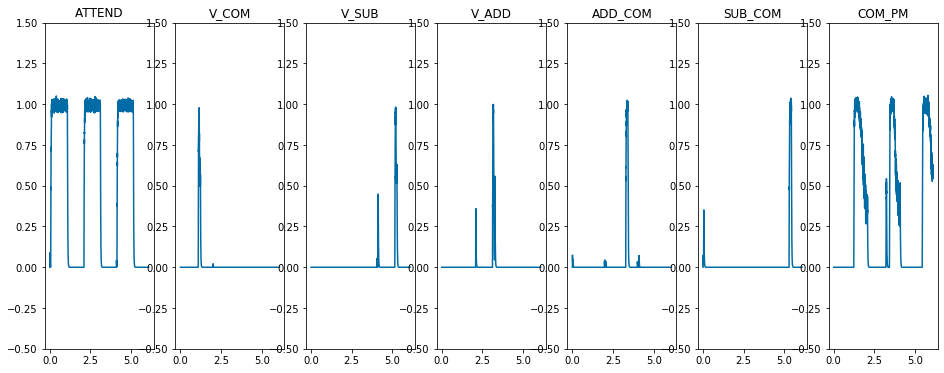

In [11]:
plt.figure(figsize=(16,6))
for i in range(routing.bg.input.size_out):
    plt.subplot(1,routing.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[p_routing_in][:,i][selected_idx])
    plt.title(routing_labels[i])
    plt.ylim(-.5,1.5)
plt.show()

plt.figure(figsize=(16,6))
for i in range(routing.bg.input.size_out):
    plt.subplot(1,routing.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[p_routing_out][:,i][selected_idx])
    plt.title(routing_labels[i])
    plt.ylim(-.5,1.5)

plt.show()

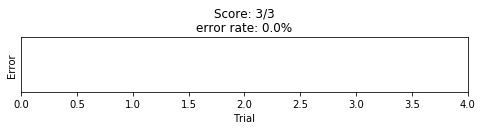

In [12]:
digit_key_to_int = {'TWO':2, 'FOUR':4, 'SIX':6, 'EIGHT':8}
digit_key_to_idx = {k:i for i,k in enumerate(digit_key_to_int.keys())}
operations_key_to_idx = {k:i for i,k in enumerate(['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'])}

n_per_condition = n_blocks_per_operation * n_trials_per_digit

RTs = np.zeros((n_different_operations, n_different_digits, n_per_condition)) 
performance = np.zeros((n_different_operations, n_different_digits, n_per_condition)) # 0:no answer / 1:wrong answer / 2:correct answer
xp_errors = []
model_actions = []
expected_actions = []

indices = np.zeros((n_different_operations, n_different_digits), dtype=int) 


def get_expected_action(trial):
    N = digit_key_to_int[trial.stimulus] 
    if trial.operation == 'CHAINED_ADD':
        N += 2
    elif trial.operation == 'CHAINED_SUB':
        N -= 2
    if N > 8:
        N = 2
    elif N < 2:
        N = 8
    expected_action = 1 + int(N > 5)
    return expected_action

t = 0
while t<T-.01:
    t += xp.trial_length
    trial = xp(t)[0]
    expected_action = get_expected_action(trial)
    expected_actions.append(expected_action)
    t_window = (np.where(np.logical_and(sim.trange() < t, sim.trange() > t-xp.trial_length))[0],)
    
    # get model's action
    model_behaviour = sim.data[p_BTN][t_window]
    if np.count_nonzero(model_behaviour) > 1:
        raise ValueError("more than one action")
    
    
    cond_idx = (operations_key_to_idx[trial.operation], digit_key_to_idx[trial.stimulus])
    trial_idx = indices[cond_idx]
    
    model_action = model_behaviour.sum()
    model_actions.append(int(model_action))
    if model_action == 0:
        trial_RT = 0
        trial_performance = 0
    else:
        action_t_idx = np.nonzero(model_behaviour[:,0])
        trial_RT = sim.trange()[t_window][action_t_idx][0] - (t-xp.trial_length) - xp.t_start
        trial_performance = int(model_action==expected_action) + 1
    
    xp_errors += [trial_performance!=2]
    
    performance[cond_idx+(trial_idx,)] = trial_performance
    RTs[cond_idx+(trial_idx,)] = trial_RT
    
    indices[cond_idx] += 1 # increment index of this condition
    


xp_errors = np.array(xp_errors, dtype=bool)

plt.figure(figsize=(8,1))
plt.eventplot(np.where(xp_errors)[0]+1, color='black')
plt.yticks([])
plt.ylabel('Error')
plt.xlim(0,len(xp_errors)+1)
plt.title('Score: '+str(number_of_total_trials-xp_errors.sum())+'/'+str(number_of_total_trials)+"\n"+
         "error rate: "+str(round(100*xp_errors.sum()/number_of_total_trials,2))+"%")
plt.xlabel('Trial')
plt.show()




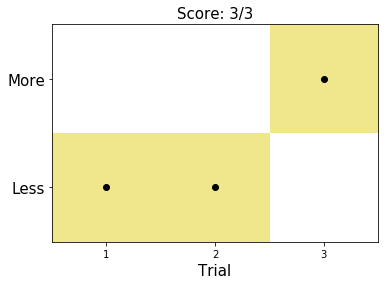

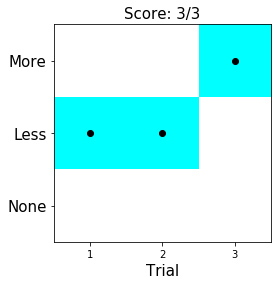

In [13]:
expected_actions_matrix = np.zeros((number_of_total_trials,3))
for i,a in enumerate(expected_actions):
    expected_actions_matrix[i,a] += 1

cmap = ListedColormap(['white', 'khaki'])
plt.imshow(expected_actions_matrix.T, origin='lower', cmap=cmap)
plt.xlabel("Trial", size=15)
plt.yticks(range(3),['None','Less','More'], size=15)
plt.xticks(range(number_of_total_trials), range(1,number_of_total_trials+1))

plt.plot(model_actions,'o',color='black')
plt.title('Score: '+str(number_of_total_trials-xp_errors.sum())+'/'+str(number_of_total_trials), size=15)
plt.ylim(0.5,2.5)
plt.show()

cmap = ListedColormap(['white', 'cyan'])
plt.imshow(expected_actions_matrix.T, origin='lower', cmap=cmap)
plt.xlabel("Trial", size=15)
plt.yticks(range(3),['None','Less','More'], size=15)
plt.xticks(range(number_of_total_trials), range(1,number_of_total_trials+1))

plt.plot(model_actions,'o',color='black')
plt.title('Score: '+str(number_of_total_trials-xp_errors.sum())+'/'+str(number_of_total_trials), size=15)
plt.show()

## Simple blocks plot

[array([336.])]


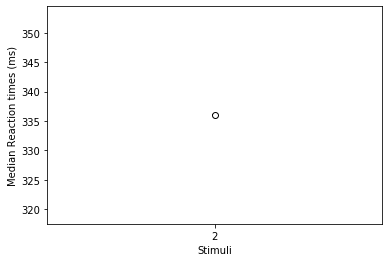

[336.]


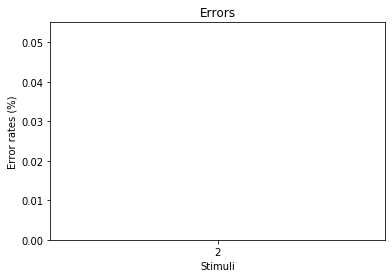

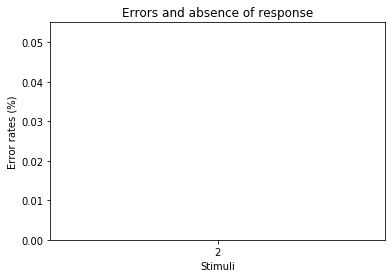

In [14]:
RTs_simple = np.copy(RTs[0,:,:]) * 1000
RTs_simple = [RTs_simple[i,:] for i in range(n_different_digits)]
print(RTs_simple)
for digit_RTs in RTs_simple:
#     print(digit_RTs.shape)
    digit_RTs = digit_RTs[digit_RTs != 0] # remove outliers (no answer)
#     print(digit_RTs.shape)
#     print('\n')

RTs_simple_median = np.array([np.median(digit_RTs) for digit_RTs in RTs_simple])
RTs_simple_std = np.array([digit_RTs.std() for digit_RTs in RTs_simple])
plt.errorbar([2,4,6,8][:n_different_digits], RTs_simple_median, yerr=RTs_simple_std, color='black', capsize=3, capthick=2, marker='.', markersize=12, markerfacecolor='white')
plt.ylabel('Median Reaction times (ms)')
plt.xlabel('Stimuli')
plt.xticks([2,4,6,8][:n_different_digits])
plt.show()

print(RTs_simple_median)




for unresponsive_as_error in [False,True]:

    if unresponsive_as_error:
        performance_simple = np.copy(performance[0,:,:])
        err_simple = np.sum(performance_simple != 2, axis=1) / n_per_condition * 100
        plt.title('Errors and absence of response')
        
    else:
        performance_simple = np.copy(performance[0,:,:])
        n_responsive = np.sum(performance_simple!=0) # count the number of responses
        err_simple = np.sum(performance_simple == 1, axis=1) / n_responsive * 100
        plt.title('Errors')

    plt.bar([2,4,6,8][:n_different_digits], err_simple, color='black')
    plt.ylabel('Error rates (%)')
    plt.xlabel('Stimuli')
    plt.xticks([2,4,6,8][:n_different_digits])
    plt.ylim(bottom=0)
    plt.show()
        

## Chained blocks plot

In [15]:
np.mean([])

/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan